# Imports and path preparations

In [1]:
import pandas as pd
from math import sqrt
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
import sys
import os

# Get the absolute path to the 'src' directory
sys.path.append(os.path.abspath(".."))
print(os.path.abspath(".."))
project_root = os.path.abspath("..")
print(sys.path)
print(project_root)

/home/julia/school/bakalarka/hospital_sim
['/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages', '/home/julia/school/bakalarka/hospital_sim']
/home/julia/school/bakalarka/hospital_sim


In [3]:
from src.main import App
from data_generator import DataGenerator
from src.process_data import DataProcessor

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
exp_layout = project_root + "/input/experiments/layouts/expLayout.json"
two_nurses = project_root + "/input/experiments/people/expTwoNurses.json" #two nurses, 4 patients each, 2 patients per room
one_nurse = project_root + "/input/experiments/people/expOneNurse.json" #one nurse, 8 patients, 2 patients per room
exp_nurse_log = project_root + "/output/expNurseLog.csv"
exp_event_log = project_root + "/output/expEventLog.csv"
event_paths = ["expEvents1.json",
"expEvents2.json",
"expEvents3.json",
"expEvents4.json",
"expEvents5.json",
"expEvents6.json",
"expEvents7.json",
"expEvents8.json",]
full_event_paths = list(map(lambda x: project_root + "/input/experiments/events/" + x, event_paths))

In [5]:
# full_event_paths = list(map(lambda x: project_root + "/input/experiments/events/" + x, event_paths))
print(full_event_paths)


['/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents1.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents2.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents3.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents4.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents5.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents6.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents7.json', '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents8.json']


In [5]:
params1 = {"event_path" : full_event_paths[0], "nurse_cnt": 2, "people_path": two_nurses, "request_assigner": "basic", "include_plans": True}
params2 = {"event_path" : full_event_paths[1], "nurse_cnt": 2, "people_path": two_nurses, "request_assigner": "other", "include_plans": True}
params3 = {"event_path" : full_event_paths[2], "nurse_cnt": 1, "people_path": one_nurse,  "request_assigner": "basic", "include_plans": True}
params4 = {"event_path" : full_event_paths[3], "nurse_cnt": 1, "people_path": one_nurse,  "request_assigner": "other", "include_plans": True}
params5 = {"event_path" : full_event_paths[4], "nurse_cnt": 2, "people_path": two_nurses, "request_assigner": "basic", "include_plans": False}
params6 = {"event_path" : full_event_paths[5], "nurse_cnt": 2, "people_path": two_nurses, "request_assigner": "other", "include_plans": False}
params7 = {"event_path" : full_event_paths[6], "nurse_cnt": 1, "people_path": one_nurse,  "request_assigner": "basic", "include_plans": False}
params8 = {"event_path" : full_event_paths[7], "nurse_cnt": 1, "people_path": one_nurse,  "request_assigner": "other", "include_plans": False}
params_lst = [params1, params2, params3, params4, params5, params6, params7, params8]

# Functions for experiment generation and running

In [6]:
def generate_exp(params):
    # exp_events = project_root + "/input/events/" + exp_event_path
    # if nurse_cnt == 1:
    #     people_file = one_nurse
    # elif nurse_cnt == 2:
    #     people_file = two_nurses
    event_gen = DataGenerator(rnd=42, layout_file=exp_layout, people_file=params["people_path"], out_file=params["event_path"], request_assigner=params["request_assigner"],
                               include_plans=params["include_plans"])
    event_gen.create_events() 

In [7]:
def run_exp(params):
    app = App(exp_layout, params["people_path"], params["event_path"], exp_nurse_log, exp_event_log)
    app.run_simulation()

In [8]:
def process_nurse_data(params):
    dp = DataProcessor(exp_nurse_log, exp_event_log, params["people_path"])
    all_results = []
    for i in range(params["nurse_cnt"]):
        nurse_results = {}
        nurse_results["nurse_dst_walked"] = dp.nurse_dst_walked(i)
        nurse_results["nurse_time_walked"] = dp.nurse_time_walked(i)
        nurse_results["nurse_time_at_own_patients"] = dp.nurse_time_at_own_patients(i)
        nurse_results["nurse_time_at_other_patients"] = dp.nurse_time_at_other_patients(i)
        nurse_results["nurse_time_resting"] = dp.nurse_time_resting(i)
        all_results.append(nurse_results)
    return all_results

In [9]:
def process_patient_data(params):
    dp = DataProcessor(exp_nurse_log, exp_event_log, params["people_path"])
    all_results = []
    for i in range(8):
        patient_results = []
        for lvl in range(4):
            if lvl == 0:
                lvl = None

            level_results = {}
            level_results["total_time_waiting"] = dp.patient_total_time_waiting(i, lvl)
            level_results["avg_time_waiting"] = dp.patient_avg_time_waiting(i, lvl) #could be changed to histogram somehow
            patient_results.append(level_results)
        all_results.append(patient_results)
    return all_results


# Running the actual experiments

In [11]:
params1 = params_lst[0]
print(params1)

{'event_path': '/home/julia/school/bakalarka/hospital_sim/input/experiments/events/expEvents1.json', 'nurse_cnt': 2, 'people_path': '/home/julia/school/bakalarka/hospital_sim/input/experiments/people/expTwoNurses.json', 'request_assigner': 'basic', 'include_plans': True}


In [ ]:
# generating each scenarion once
%%capture
for params in params_lst:
    generate_exp(params)

In [ ]:
# running each scenario once
%%capture
nurse_results = []
patient_results = []
done = []
for i, params in enumerate(params_lst):  
    run_exp(params)
    done.append(i)
    exp_results_nurse = process_nurse_data(params)
    nurse_results.append(exp_results_nurse)
    exp_results_patient = process_patient_data(params)
    patient_results.append(exp_results_patient)

In [18]:
# generating and running each scenario n times
nurse_results = []
patient_results = []
done = []
for i, params in enumerate(params_lst):
    event_gen = DataGenerator(rnd=42, layout_file=exp_layout, people_file=params["people_path"], out_file=params["event_path"], request_assigner=params["request_assigner"],
                               include_plans=params["include_plans"]) #data generator for that particular scenario
    nurse_results_scenario = []
    patient_results_scenario = []
    for _ in range(2):
        event_gen.create_events() 
        run_exp(params)
        done.append(i)
        exp_results_nurse = process_nurse_data(params)
        nurse_results_scenario.append(exp_results_nurse)
        exp_results_patient = process_patient_data(params)
        patient_results_scenario.append(exp_results_patient)
    nurse_results.append(nurse_results_scenario)
    patient_results.append(patient_results_scenario)

{'time': 2867.554752696838, 'patient': 0, 'level': 2, 'duration': 146.9536500409154}
{'time': 2148.660568607353, 'patient': 0, 'level': 2, 'duration': 44.996237372700435}
{'time': 1653.2960110771219, 'patient': 0, 'level': 2, 'duration': 51.43002268829112}
{'time': 2343.1985026158704, 'patient': 0, 'level': 2, 'duration': 138.2998158400237}
{'time': 3378.7897524567006, 'patient': 0, 'level': 2, 'duration': 178.83173389368264}
{'time': 2222.9334346597793, 'patient': 0, 'level': 2, 'duration': 31.059945782957612}
{'time': 83.02473014909673, 'patient': 0, 'level': 2, 'duration': 89.97914575728832}
{'time': 167.99638756901552, 'patient': 0, 'level': 3, 'duration': 64.91570106454563}
{'time': 326.18316431815487, 'patient': 0, 'level': 2, 'duration': 87.3692986900744}
{'time': 2132.692447903353, 'patient': 1, 'level': 2, 'duration': 121.13172778521576}
{'time': 613.8868452742495, 'patient': 1, 'level': 2, 'duration': 172.33283058799998}
{'time': 3476.275319068414, 'patient': 1, 'level': 3, '

/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'time': 2891.3031229676253, 'patient': 0, 'level': 2, 'duration': 177.51347113422645}
{'time': 1435.767992800391, 'patient': 0, 'level': 3, 'duration': 149.75176874768266}
{'time': 542.5831582755461, 'patient': 0, 'level': 2, 'duration': 134.3719210186323}
{'time': 3090.0916973293915, 'patient': 0, 'level': 2, 'duration': 63.036157134832244}
{'time': 2560.138316776864, 'patient': 0, 'level': 3, 'duration': 82.2998980937594}
{'time': 346.23558392911474, 'patient': 0, 'level': 3, 'duration': 89.63580316312834}
{'time': 1863.9048618989284, 'patient': 0, 'level': 3, 'duration': 131.3535175558921}
{'time': 2646.77802926678, 'patient': 0, 'level': 2, 'duration': 111.21719607413488}
{'time': 2504.823837642296, 'patient': 0, 'level': 2, 'duration': 56.24323906439042}
{'time': 1859.8892085756513, 'patient': 1, 'level': 2, 'duration': 179.43805496368864}
{'time': 3475.509664639657, 'patient': 1, 'level': 2, 'duration': 162.39545147840096}
{'time': 679.3455900289657, 'patient': 1, 'level': 2, 'd

/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/_core/_methods.

{'time': 2891.3031229676253, 'patient': 0, 'level': 2, 'duration': 177.51347113422645}
{'time': 1435.767992800391, 'patient': 0, 'level': 3, 'duration': 149.75176874768266}
{'time': 542.5831582755461, 'patient': 0, 'level': 2, 'duration': 134.3719210186323}
{'time': 3090.0916973293915, 'patient': 0, 'level': 2, 'duration': 63.036157134832244}
{'time': 2560.138316776864, 'patient': 0, 'level': 3, 'duration': 82.2998980937594}
{'time': 346.23558392911474, 'patient': 0, 'level': 3, 'duration': 89.63580316312834}
{'time': 1863.9048618989284, 'patient': 0, 'level': 3, 'duration': 131.3535175558921}
{'time': 2646.77802926678, 'patient': 0, 'level': 2, 'duration': 111.21719607413488}
{'time': 2504.823837642296, 'patient': 0, 'level': 2, 'duration': 56.24323906439042}
{'time': 1859.8892085756513, 'patient': 1, 'level': 2, 'duration': 179.43805496368864}
{'time': 3475.509664639657, 'patient': 1, 'level': 2, 'duration': 162.39545147840096}
{'time': 679.3455900289657, 'patient': 1, 'level': 2, 'd

/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'time': 2891.3031229676253, 'patient': 0, 'level': 2, 'duration': 177.51347113422645}
{'time': 1435.767992800391, 'patient': 0, 'level': 3, 'duration': 149.75176874768266}
{'time': 542.5831582755461, 'patient': 0, 'level': 2, 'duration': 134.3719210186323}
{'time': 3090.0916973293915, 'patient': 0, 'level': 2, 'duration': 63.036157134832244}
{'time': 2560.138316776864, 'patient': 0, 'level': 3, 'duration': 82.2998980937594}
{'time': 346.23558392911474, 'patient': 0, 'level': 3, 'duration': 89.63580316312834}
{'time': 1863.9048618989284, 'patient': 0, 'level': 3, 'duration': 131.3535175558921}
{'time': 2646.77802926678, 'patient': 0, 'level': 2, 'duration': 111.21719607413488}
{'time': 2504.823837642296, 'patient': 0, 'level': 2, 'duration': 56.24323906439042}
{'time': 1859.8892085756513, 'patient': 1, 'level': 2, 'duration': 179.43805496368864}
{'time': 3475.509664639657, 'patient': 1, 'level': 2, 'duration': 162.39545147840096}
{'time': 679.3455900289657, 'patient': 1, 'level': 2, 'd

/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/julia/school/bakalarka/simVenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'time': 2867.554752696838, 'patient': 0, 'level': 2, 'duration': 146.9536500409154}
{'time': 2148.660568607353, 'patient': 0, 'level': 2, 'duration': 44.996237372700435}
{'time': 1653.2960110771219, 'patient': 0, 'level': 2, 'duration': 51.43002268829112}
{'time': 2343.1985026158704, 'patient': 0, 'level': 2, 'duration': 138.2998158400237}
{'time': 3378.7897524567006, 'patient': 0, 'level': 2, 'duration': 178.83173389368264}
{'time': 2222.9334346597793, 'patient': 0, 'level': 2, 'duration': 31.059945782957612}
{'time': 83.02473014909673, 'patient': 0, 'level': 2, 'duration': 89.97914575728832}
{'time': 167.99638756901552, 'patient': 0, 'level': 3, 'duration': 64.91570106454563}
{'time': 326.18316431815487, 'patient': 0, 'level': 2, 'duration': 87.3692986900744}
{'time': 2132.692447903353, 'patient': 1, 'level': 2, 'duration': 121.13172778521576}
{'time': 613.8868452742495, 'patient': 1, 'level': 2, 'duration': 172.33283058799998}
{'time': 3476.275319068414, 'patient': 1, 'level': 3, '

## Test prints

In [ ]:
run_exp(params_lst[0])

In [ ]:
res = process_patient_data(params_lst[0])
for i, patient in enumerate(res):
    print(i)
    for lvl in patient:
        print(lvl)

In [22]:
for res in nurse_results:
    print(res)

[[{'nurse_dst_walked': 142.0, 'nurse_time_walked': np.float64(142.0), 'nurse_time_at_own_patients': np.float64(3267.419399976401), 'nurse_time_at_other_patients': 0, 'nurse_time_resting': np.float64(448.0361894299999)}, {'nurse_dst_walked': 235.65676902744008, 'nurse_time_walked': np.float64(235.6567690274403), 'nurse_time_at_own_patients': np.float64(2696.7678618967393), 'nurse_time_at_other_patients': 0, 'nurse_time_resting': np.float64(925.0309584822214)}], [{'nurse_dst_walked': 283.78219735829407, 'nurse_time_walked': np.float64(283.7821973582945), 'nurse_time_at_own_patients': np.float64(6506.513299963409), 'nurse_time_at_other_patients': 0, 'nurse_time_resting': np.float64(801.3740726918982)}, {'nurse_dst_walked': 480.0, 'nurse_time_walked': np.float64(480.0), 'nurse_time_at_own_patients': np.float64(6198.806463578345), 'nurse_time_at_other_patients': 0, 'nurse_time_resting': np.float64(912.8631064352567)}]]
[[{'nurse_dst_walked': 360.0, 'nurse_time_walked': np.float64(360.0), 'n

In [21]:
for i, exp in enumerate(patient_results):
    print("\n---------------- EXPERIMENT ", i, "---------------------------")
    for l, run in enumerate(exp):
        print("RUN", l)
        for j, patient in enumerate(run):
            print("\tpatient", j)
            for k, lvl in enumerate(patient):
                print("\t\tlevel", k, lvl)


---------------- EXPERIMENT  0 ---------------------------
RUN 0
	patient 0
		level 0 {'total_time_waiting': np.float64(3293.6861759005383), 'avg_time_waiting': np.float64(365.9651306556153)}
		level 1 {'total_time_waiting': 0, 'avg_time_waiting': np.float64(nan)}
		level 2 {'total_time_waiting': np.float64(3220.7704748359924), 'avg_time_waiting': np.float64(402.59630935449906)}
		level 3 {'total_time_waiting': np.float64(72.91570106454563), 'avg_time_waiting': np.float64(72.91570106454563)}
	patient 1
		level 0 {'total_time_waiting': np.float64(1101.9915893653501), 'avg_time_waiting': np.float64(183.66526489422503)}
		level 1 {'total_time_waiting': 0, 'avg_time_waiting': np.float64(nan)}
		level 2 {'total_time_waiting': np.float64(1026.299523989344), 'avg_time_waiting': np.float64(205.25990479786878)}
		level 3 {'total_time_waiting': np.float64(75.69206537600621), 'avg_time_waiting': np.float64(75.69206537600621)}
	patient 2
		level 0 {'total_time_waiting': np.float64(1451.1111440776

In [35]:
for i, exp in enumerate(nurse_results):
    print("\n---------------- EXPERIMENT ", i, "---------------------------")
    for l, run in enumerate(exp):
        print("RUN", l)
        for j, nurse in enumerate(run):
            print("\tnurse", j)
            for k, stat in enumerate(nurse):
                print("\t\t", stat, nurse[stat])


---------------- EXPERIMENT  0 ---------------------------
RUN 0
	nurse 0
		 nurse_dst_walked 142.0
		 nurse_time_walked 142.0
		 nurse_time_at_own_patients 3267.419399976401
		 nurse_time_at_other_patients 0
		 nurse_time_resting 448.0361894299999
	nurse 1
		 nurse_dst_walked 235.65676902744008
		 nurse_time_walked 235.6567690274403
		 nurse_time_at_own_patients 2696.7678618967393
		 nurse_time_at_other_patients 0
		 nurse_time_resting 925.0309584822214
RUN 1
	nurse 0
		 nurse_dst_walked 283.78219735829407
		 nurse_time_walked 283.7821973582945
		 nurse_time_at_own_patients 6506.513299963409
		 nurse_time_at_other_patients 0
		 nurse_time_resting 801.3740726918982
	nurse 1
		 nurse_dst_walked 480.0
		 nurse_time_walked 480.0
		 nurse_time_at_own_patients 6198.806463578345
		 nurse_time_at_other_patients 0
		 nurse_time_resting 912.8631064352567

---------------- EXPERIMENT  1 ---------------------------
RUN 0
	nurse 0
		 nurse_dst_walked 360.0
		 nurse_time_walked 360.0
		 nurse_time

# Plot data

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[212.89109867914703, 357.82838451372004, 465.6488350081031, 537.1147485186104, 907.6488350081031, 0.0, 872.6488350081031, 0.0, 227.89109867914703, 371.82838451372004, 507.0, 503.73782141763354, 914.6488350081031, 0.0, 879.0, 0.0]


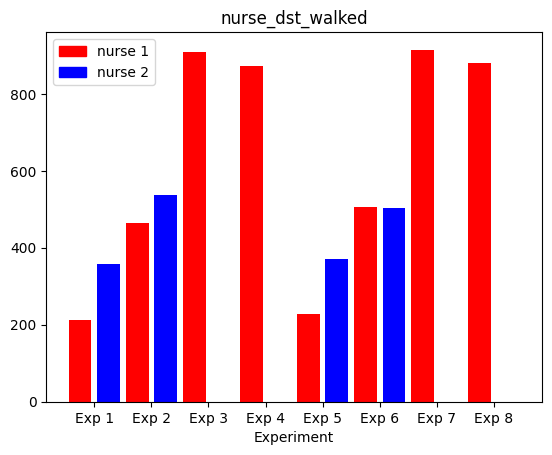

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[np.float64(212.89109867914726), np.float64(357.82838451372015), np.float64(465.6488350081031), np.float64(537.1147485186104), np.float64(907.6488350081036), 0.0, np.float64(872.6488350081031), 0.0, np.float64(227.89109867914726), np.float64(371.82838451372015), np.float64(507.0), np.float64(503.737821417634), np.float64(914.6488350081036), 0.0, np.float64(879.0), 0.0]


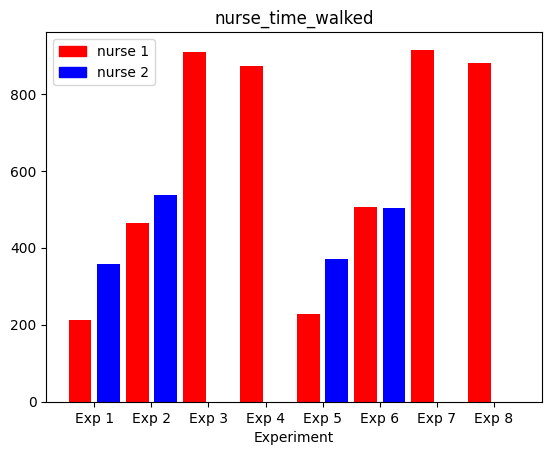

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[np.float64(4886.966349969905), np.float64(4447.7871627375425), np.float64(2843.662410587892), np.float64(2614.9782092531705), np.float64(9334.75351270745), 0.0, np.float64(9334.753512707452), 0.0, np.float64(4886.966349969905), np.float64(4447.7871627375425), np.float64(2789.079246712942), np.float64(2570.64686680371), np.float64(9334.75351270745), 0.0, np.float64(9334.753512707448), 0.0]


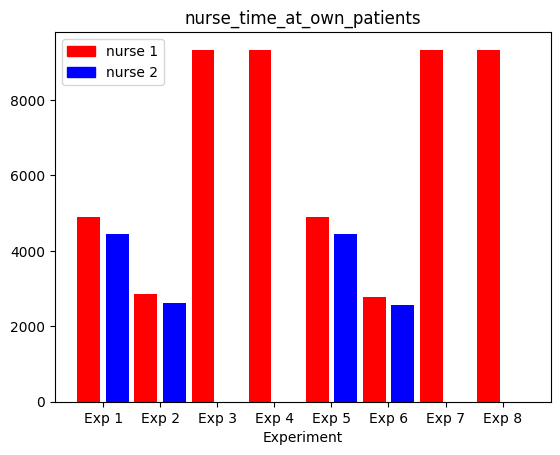

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[0.0, 0.0, np.float64(1832.8089534843707), np.float64(2043.3039393820147), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, np.float64(1877.1402959338293), np.float64(2097.8871032569655), 0.0, 0.0, 0.0, 0.0]


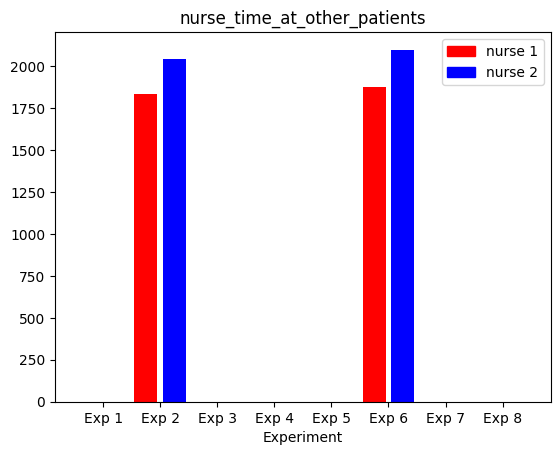

['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8']
[np.float64(624.705131060949), np.float64(918.947032458739), np.float64(224.58533813330087), np.float64(171.30864005987132), np.float64(862.5677684506522), 0.0, np.float64(339.90115048948246), 0.0, np.float64(648.205131060949), np.float64(943.447032458739), np.float64(244.61757116819535), np.float64(245.56532233665757), np.float64(897.5677684506522), 0.0, np.float64(312.84178951782405), 0.0]


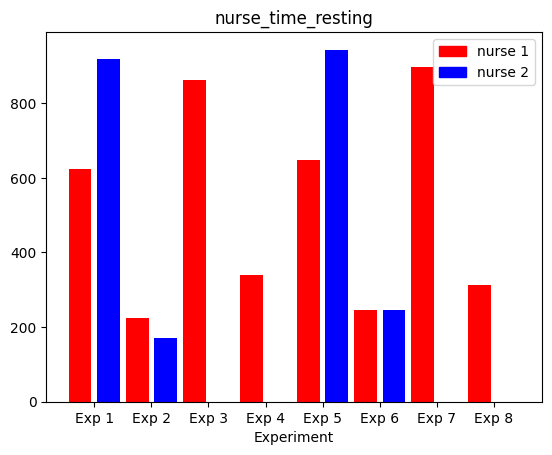

In [ ]:
def plot_nurse_stat(stat_name):
    values = [0 for _ in range(len(nurse_results) * 2 )] # amounts to be plotted in bar chart
    runs = len(nurse_results[0])
    for i, exp in enumerate(nurse_results):
        for run in exp:
            values[i * 2] += run[0][stat_name]
            # values.append(run[0][stat_name])
            if len(run) == 2: # there are two nurses, so update the second bar of that experiment
                # values.append(run[1][stat_name])
                values[i * 2 + 1] += run[1][stat_name]
            # else:
                # values.append(0)

    # values has the sum of all results, average them
    values = list(map(lambda x: x / runs, values)) 

    labels = ["Exp " + str(x + 1) for x in range(8)] # experiment scenario names
    colors = ['red' if i % 2 == 0 else 'blue' for i in range(len(values))] #alternating colors for nurses
    print(labels)
    print(values)
    x = np.arange(len(values))

    # plot the actual bars
    plt.bar(x, values, color=colors)

    # write labels under each pair of values
    plt.xticks(ticks=np.arange(0.5, len(values), 2), labels=labels)

    # red_patch = plt.Line2D([0], [0], color='red', lw=4, label='nurse 1')
    # blue_patch = plt.Line2D([0], [0], color='blue', lw=4, label='nurse 2')
    # create legend
    red_patch = mpatches.Circle((0, 0), radius=0.1, color='red', label='nurse 1')
    blue_patch = mpatches.Circle((0, 0), radius=0.1, color='blue', label='nurse 2')
    plt.legend(handles=[red_patch, blue_patch])

    # titles
    plt.xlabel("Experiment")
    plt.ylabel("")
    plt.title(stat_name)

    plt.show()

nurse_stats = nurse_results[0][0][0].keys()
for stat in nurse_stats:
    plot_nurse_stat(stat)

In [ ]:
def plot_patient_stat(stat_name, level):
    if level == 0:
        level_title = "all"
    else:
        level_title = level
    values = []
    for i, exp in enumerate(patient_results):
        for j, patient in enumerate(exp):
            values.append(patient[level][stat_name])

    print(values)
    print(len(values))

    labels = ["Exp " + str(x) for x in range(8)]
    # colors = ['red' if i % 2 == 0 else 'blue' for i in range(len(values))]
    x = np.arange(len(values))
    plt.bar(x, values, color="blue")
    plt.xticks(ticks=np.arange(3.5, len(values), 8), labels=labels)

    plt.xlabel("Experiment")
    plt.ylabel("")
    plt.title(stat_name + " level " + str(level_title))

    # Show the chart
    plt.show()

for i in range(4):
    plot_patient_stat("total_time_waiting", i)

for i in range(4):
    plot_patient_stat("avg_time_waiting", i)

## Test prints

In [14]:
df = pd.read_csv(project_root + "/output/testNurseLog.csv")
df

,time,nurse,x,y,event,action,patient
0,0.000000,0,3.0,3.0,131,assign event,0.0
1,3.000000,0,6.0,3.0,131,move to,0.0
2,7.000000,0,6.0,7.0,131,move to,0.0
3,10.000000,0,3.0,7.0,131,move to,0.0
4,25.027670,0,3.0,7.0,131,unassign event,0.0
...,...,...,...,...,...,...,...
645,8401.562386,0,3.0,7.0,164,assign event,NaN
646,8404.562386,0,6.0,7.0,164,move to,NaN
647,8408.562386,0,6.0,3.0,164,move to,NaN
648,8411.562386,0,3.0,3.0,164,move to,NaN


In [17]:
time_rows = df[(df['nurse'] == 0) & (df['patient'] == 0) & (df['action'] == "time at patient")].event.tolist()
time_rows


[82, 131, 81, 79, 139, 75, 80, 78, 76, 77, 74]

In [18]:
df115 = df[df['event'] == 82].reset_index(drop=True)
df115

,time,nurse,x,y,event,action,patient
0,167.996388,0,3.0,7.0,82,assign event,0.0
1,266.406885,0,3.0,7.0,82,time at patient,0.0
2,266.406885,0,3.0,7.0,82,finish event,0.0


In [19]:
# Find the index of the row where action is 'time at patient'
time_at_patient_idx = df115[df115['action'] == 'time at patient'].index[0]
print(time_at_patient_idx)

total_time = 0
int_end_time = df115.loc[time_at_patient_idx].time #end of current calculated interval
# Iterate backward from this index to find the first occurrence of 'move to'
for idx in range(time_at_patient_idx, -1, -1):
    line = df115.loc[idx]
    action = line["action"]
    if action == 'move to' or idx == 0:
        total_time += int_end_time - line["time"]
        break
    if action == 'assign event':
        total_time += int_end_time - line["time"]
    elif action == 'unassign event':
        int_end_time = line["time"]
    print(idx, action, total_time)

print(total_time)

1
1 time at patient 0
98.41049763255538


In [29]:
df115.iloc[-1]

time        2928.664217
nurse                 0
x                  14.0
y                   3.0
event               115
action     finish event
patient             5.0
Name: 210, dtype: object

In [22]:
req_levels = [2, 3]
level_probabilities = [0.75, 0.25]
level = np.random.choice(req_levels, p=level_probabilities)
req = {}
req["level"] = level

print(req["level"])

2


In [26]:
val = np.int64(2)
print(type(int(val)))

<class 'int'>
